# Sentinel Hub OGC services

<div class="alert alert-warning">

<b>Disclaimer:</b>
    
Sentinel Hub service has a dedicated [Process API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html) that extends the limiting capabilities of the standard OGC endpoints. 
We advise you to move to Process API and enjoy the full power of Sentinel Hub services. See the [notebook](./process_request.ipynb) with Process API examples.
</div>

## Web Map Service (WMS) and Web Coverage Service (WCS)

In this example notebook we show how to use WMS and WCS services provided by [Sentinel Hub deployed on Copernicues Data Space Ecosystem](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/OGC.html) to download satellite imagery. We describe how to use various parameters and configurations to obtain either processed products or raw band data.

We start with examples using Sentinel-2 L1C data and then show how to also obtain Sentinel-2 L2A, Sentinel-1, and DEM data.

## Prerequisites

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import getpass

import datetime

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    WcsRequest,
    WmsRequest,
    SHConfig,
)

Note: `matplotlib` is not a dependency of `sentinelhub`.

## Credentials

To obtain your `client_id` & `client_secret`, you need to navigate to your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings, you can create a new OAuth client to generate these credentials. More detailed instructions can be found on the corresponding [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Following these instructions, you can create a profile specifically for using the package to access Copernicus Data Space Ecosystem data collections. This is useful as changes to the config class in your notebook are usually only temporary and by saving the configuration to your profile, you don't have to generate new credentials or overwrite/change the default profile every time you run or write a new Jupyter Notebook. 

If you are using the Sentinel Hub Python package for the Copernicus Data Space Ecosystem for the first time, you should create a profile specifically for the Copernicus Data Space Ecosystem. You can do this by uncommenting the following cell:

In [ ]:
# Only run this cell if you have not created a configuration.

# config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
# config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
# config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing {`profile_name`}.

In [3]:
# config = SHConfig("cdse")

### Defining helper functions

In [4]:
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

#### Setting area of interest

We will download Sentinel-2 imagery of [Betsiboka Estuary](https://en.wikipedia.org/wiki/Betsiboka_River) such as the one shown below (taken by Sentinel-2 on 2017-12-15):   
![title](data/wms_TRUE_COLOR_EPSG4326_-16.15_46.16_-15.58_46.51_2017-12-15T07-12-03_512X856.png)

The bounding box in _WGS84_ coordinate system is (longitude and latitude coordinates of upper left and lower right corners):

In [5]:
betsiboka_coords_wgs84 = (46.16, -16.15, 46.51, -15.58)

All requests require bounding box to be given as an instance of `sentinelhub.geometry.BBox` with corresponding Coordinate Reference System (`sentinelhub.geometry.CRS`). In our case it is in _WGS84_ and we can use the predefined _WGS84_ coordinate reference system from `sentinelhub.geometry.CRS`.

In [6]:
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)

### WMS request 

#### Example 1: True color (PNG) on a specific date

We need to specify the following arguments in the initialization of a `WmsRequest`:

 * `layer` - set it to `'TRUE-COLOR-S2-L1C'`
    * In case you are not using a configuration based on **Python scripts template** you will now have to create a layer named `TRUE-COLOR-S2-L1C` yourself. In [Sentinel Hub Dashboard of Copernicus Data Space Ecosystem](https://shapps.dataspace.copernicus.eu/dashboard/#/) go to your configuration, add new layer which will use Sentinel-2 L1C data collection and predefined product `TRUE COLOR, RGB Visualization` for `Data processing` parameter.
 * `bbox` - see above
 * `time` - acquisition date 
     * we'll set it to 2017-12-15
 * `width` and `height` - width and height of a returned image
     * we'll set them to 512 and 856, respectively
     * we could only set one of the two parameters and the other one would be set automatically in a way that image would best fit bounding box ratio 
 * `instance_id` - see above
 
All of the above arguments are obligatory and have to be set for all `WmsRequest`.

In [7]:
INSTANCE_ID = "d3dcf80d-d84a-4322-9d02-d813d34bc93b"
config.instance_id = INSTANCE_ID

In [8]:
wms_true_color_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    layer="TRUE-COLOR-S2-L1C",
    bbox=betsiboka_bbox,
    time="2017-12-15",
    width=512,
    height=856,
    config=config,
)

In [9]:
wms_true_color_img = wms_true_color_request.get_data()

Method `get_data()` will always return a list images in form of numpy arrays.

In [10]:
print(
    "Returned data is of type = %s and length %d."
    % (type(wms_true_color_img), len(wms_true_color_img))
)

Returned data is of type = <class 'list'> and length 1.


In [11]:
print(
    "Single element in the list is of type {} and has shape {}".format(
        type(wms_true_color_img[-1]), wms_true_color_img[-1].shape
    )
)

Single element in the list is of type <class 'numpy.ndarray'> and has shape (856, 512, 4)


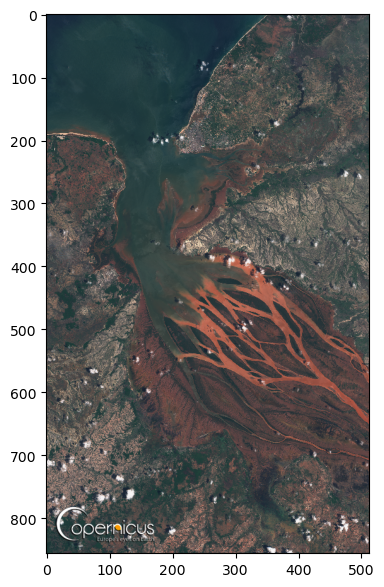

In [12]:
plot_image(wms_true_color_img[-1])

#### Example 2: True color of the latest acquisition

In order to get the latest Sentinel-2 acquisition set the `time` argument to `'latest'`.

In [13]:
wms_true_color_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    layer="TRUE-COLOR-S2-L1C",
    bbox=betsiboka_bbox,
    time="latest",
    width=512,
    height=856,
    config=config,
)

In [14]:
wms_true_color_img = wms_true_color_request.get_data()

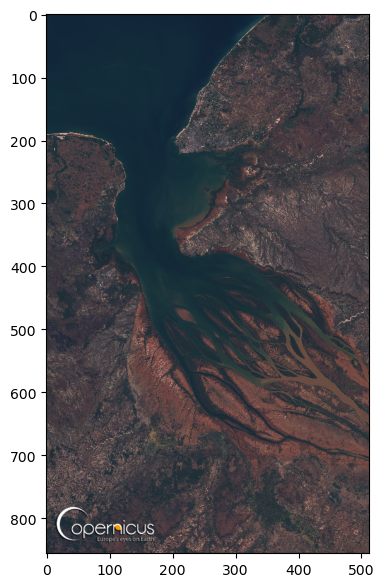

In [15]:
plot_image(wms_true_color_img[-1])

In [16]:
print(
    "The latest Sentinel-2 image of this area was taken on {}.".format(
        wms_true_color_request.get_dates()[-1]
    )
)

The latest Sentinel-2 image of this area was taken on 2024-06-16 07:14:13.045000.


In case a part of the image above is completely white that is because the latest acquisition only partially intersected the specified bounding box. To avoid that we could use a `time_difference` parameter described in [Example 8](#Example-8:-Merging-two-or-more-download-requests-into-one).

#### Example 3: True color of the multiple acquisitions in certain time window

In order to get all Sentinel-2 acquisitions taken in a certain time interval set the `time` argument to tuple with two elements (`start date`,`end date`).

In [17]:
wms_true_color_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    layer="TRUE-COLOR-S2-L1C",
    bbox=betsiboka_bbox,
    time=("2017-12-01", "2017-12-31"),
    width=512,
    height=856,
    config=config,
)

In [18]:
wms_true_color_img = wms_true_color_request.get_data()

In [19]:
print(
    "There are %d Sentinel-2 images available for December 2017."
    % len(wms_true_color_img)
)

There are 6 Sentinel-2 images available for December 2017.


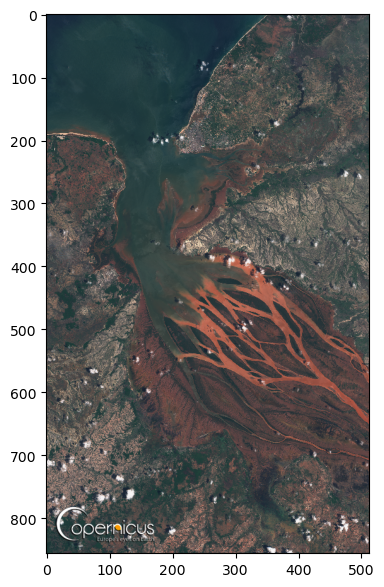

In [20]:
plot_image(wms_true_color_img[2])

In [21]:
print("These %d images were taken on the following dates:" % len(wms_true_color_img))
for index, date in enumerate(wms_true_color_request.get_dates()):
    print(" - image %d was taken on %s" % (index, date))

These 6 images were taken on the following dates:
 - image 0 was taken on 2017-12-05 07:13:55.535000
 - image 1 was taken on 2017-12-10 07:14:01.796000
 - image 2 was taken on 2017-12-15 07:13:55.013000
 - image 3 was taken on 2017-12-20 07:14:01.499000
 - image 4 was taken on 2017-12-25 07:13:55.643000
 - image 5 was taken on 2017-12-30 07:14:00.529000


#### Example 4: True color of the multiple acquisitions in certain time window with cloud coverage less than 30%

In order to get only Sentinel-2 acquisitions with cloud coverage less than certain amount set `maxcc` argument to that value. Note that this cloud coverage is estimated on the entire Sentinel-2 tile and not just for the region defined by our bounding box.

In [22]:
wms_true_color_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    layer="TRUE-COLOR-S2-L1C",
    bbox=betsiboka_bbox,
    time=("2017-12-01", "2017-12-31"),
    width=512,
    height=856,
    maxcc=0.4,
    config=config,
)

In [23]:
wms_true_color_img = wms_true_color_request.get_data()

In [24]:
print(
    "There are %d Sentinel-2 images available for December 2017 with cloud coverage less than %1.0f%%."
    % (len(wms_true_color_img), wms_true_color_request.maxcc * 100.0)
)

There are 1 Sentinel-2 images available for December 2017 with cloud coverage less than 40%.


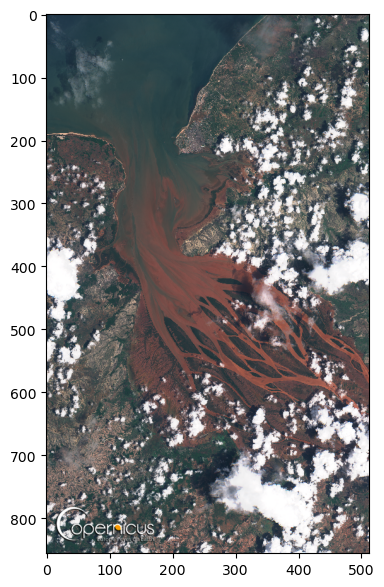

In [25]:
plot_image(wms_true_color_img[-1])

In [26]:
print("These %d images were taken on the following dates:" % len(wms_true_color_img))
for index, date in enumerate(wms_true_color_request.get_dates()):
    print(" - image %d was taken on %s" % (index, date))

These 1 images were taken on the following dates:
 - image 0 was taken on 2017-12-20 07:14:01.499000


#### Example 5: All Sentinel-2's raw band values 

Now let's use a layer named `BANDS-S2-L1C` which will return all Sentinel-2 spectral bands with raw values.

If you are not using a configuration based on **Python scripts template** you will again have to create such layer manually. In that case define `Data processing` parameter with the following custom script:
```Javascript
return [B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12]
```

We have to set the `image_format` argument to `sentinelhub.constants.MimeType.TIFF`, since we can't pack all Sentinel-2's 13 bands into a png image. A type of returned data (uint8, uint16 or float32) should be set in an layer definition in the Dashboard.

In [27]:
wms_bands_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    layer="BANDS-S2-L1C",
    bbox=betsiboka_bbox,
    time="2017-12-15",
    width=512,
    height=856,
    image_format=MimeType.TIFF,
    config=config,
)

wms_bands_img = wms_bands_request.get_data()

In [28]:
wms_bands_img[-1][:, :, 12].shape

(856, 512)

Image showing SWIR band B12

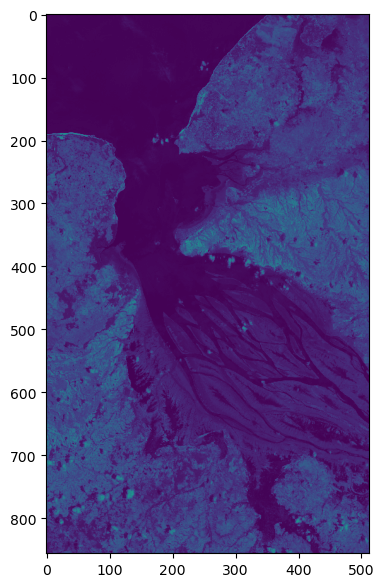

In [29]:
plot_image(wms_bands_img[-1][:, :, 12])

From raw bands we can also construct a true color image

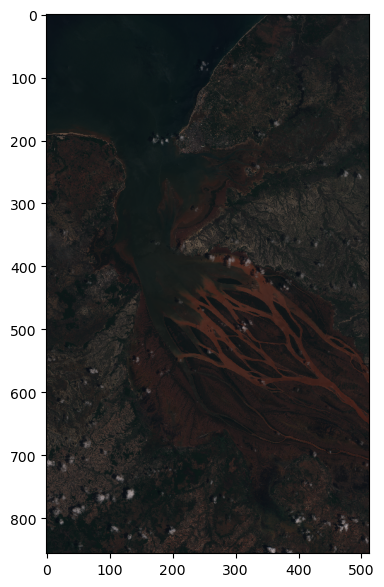

In [30]:
plot_image(wms_bands_img[-1][:, :, [3, 2, 1]], 2.5)

Last band is [`dataMask`](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/#available-bands-and-data), in this case showing we have data over the whole image.

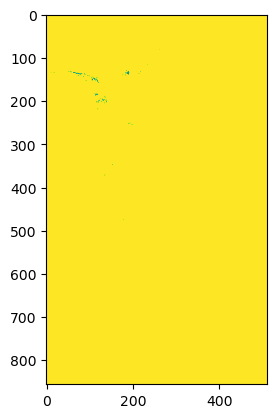

In [31]:
plt.imshow(wms_bands_img[-1][:, :, -1], vmin=0, vmax=1);

#### Example 6: Save downloaded data to disk and read it from disk

All downloaded data can be saved to disk and later read from it. Simply specify the location on disk where data should be saved (or loaded from) via `data_folder` argument of request's constructor and set the argument `save_data` of `get_data` method to `True`.

In [32]:
wms_bands_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    data_folder="test_dir",
    layer="BANDS-S2-L1C",
    bbox=betsiboka_bbox,
    time="2017-12-15",
    width=512,
    height=856,
    image_format=MimeType.TIFF,
    config=config,
)

In [33]:
%%time
wms_bands_img = wms_bands_request.get_data(save_data=True)

CPU times: user 38.7 ms, sys: 11.1 ms, total: 49.8 ms
Wall time: 222 ms


The output directory has been created and a tiff file with all 13 bands was saved into the following structure:

In [34]:
import os

for folder, _, filenames in os.walk(wms_bands_request.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

test_dir/11c3d4d183c49cc43edbefd1fe09176d/request.json
test_dir/11c3d4d183c49cc43edbefd1fe09176d/response.tiff
test_dir/6010d416b76925d6ff045c57962858c8/request.json
test_dir/6010d416b76925d6ff045c57962858c8/response.tiff


Since data has been already downloaded the next request will read the data from disk instead of downloading it. That will be much faster.

In [35]:
wms_bands_request_from_disk = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    data_folder="test_dir",
    layer="BANDS-S2-L1C",
    bbox=betsiboka_bbox,
    time="2017-12-15",
    width=512,
    height=856,
    image_format=MimeType.TIFF,
    config=config,
)

In [36]:
%%time

wms_bands_img_from_disk = wms_bands_request_from_disk.get_data()

CPU times: user 37.4 ms, sys: 17.5 ms, total: 54.8 ms
Wall time: 218 ms


In [37]:
if np.array_equal(wms_bands_img[-1], wms_bands_img_from_disk[-1]):
    print("Arrays are equal.")
else:
    print("Arrays are different.")

Arrays are equal.


If you need to redownload the data again, just set the `redownload` argument of `get_data()` method to `True`. 

In [ ]:
%%time
wms_bands_img_redownload = wms_bands_request_from_disk.get_data(redownload=True)

CPU times: user 48.7 ms, sys: 13.9 ms, total: 62.6 ms
Wall time: 3.86 s


#### Example 7: Save downloaded data directly to disk

The `get_data` method returns a list of numpy arrays and can save the downloaded data to disk, as we have seen in the previous example. Sometimes you would just like to save the data directly to disk for later use. You can do that by using `save_data` method instead.

In [ ]:
wms_true_color_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    data_folder="test_dir_tiff",
    layer="TRUE-COLOR-S2-L1C",
    bbox=betsiboka_bbox,
    time=("2017-12-01", "2017-12-31"),
    width=512,
    height=856,
    image_format=MimeType.TIFF,
    config=config,
)

In [ ]:
%%time
wms_true_color_request.save_data()

The output directory has been created and tiff files for all 6 images should be in it.

In [ ]:
os.listdir(wms_true_color_request.data_folder)

#### Example 8: Merging two or more download requests into one

If the bounding box spans over two or more Sentinel-2 tiles and each of them has slightly different time stamp, then download request will be created for each time stamp. Therefore we will obtain two or more images which could be completely the same or partially blank. It depends on whether the tiles from the same orbit are from the same or from two different data strips.

Let's look at the specific example. Again, we're going to look at Betsiboka estuary, but we'll increase the bounding box so that we cover an area of two different Senteinel-2 tiles.

In [ ]:
betsiboka_bbox_large = BBox((45.88, -16.12, 47.29, -15.45), crs=CRS.WGS84)

wms_true_color_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    layer="TRUE-COLOR-S2-L1C",
    bbox=betsiboka_bbox_large,
    time="2019-07-18",
    width=960,
    image_format=MimeType.PNG,
    config=config,
)

wms_true_color_img = wms_true_color_request.get_data()

In [ ]:
plot_image(wms_true_color_img[0])
plot_image(wms_true_color_img[1])

Clearly these are the same images and we usually would want to get only one. We can do that by widening the time interval in which two or more download requests are considered to be the same. In our example it is enough to widen the time window for 10 minutes, but usually it can be up to two hours. This is done by setting the `time_difference` argument.

In [ ]:
wms_true_color_request_with_deltat = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    layer="TRUE-COLOR-S2-L1C",
    bbox=betsiboka_bbox_large,
    time="2019-07-18",
    width=960,
    image_format=MimeType.PNG,
    time_difference=datetime.timedelta(hours=2),
    config=config,
)

wms_true_color_img = wms_true_color_request_with_deltat.get_data()

In [ ]:
print("These %d images were taken on the following dates:" % len(wms_true_color_img))
for index, date in enumerate(wms_true_color_request_with_deltat.get_dates()):
    print(" - image %d was taken on %s" % (index, date))

In [ ]:
plot_image(wms_true_color_img[-1])

### WCS request

The use of `WcsRequest` is exactly the same as of the `WmsRequest` shown above. The only difference is that instead of specifying image size we specify the spatial resolution of the image. We do that by setting the `resx` and `resy` arguments to the desired resolution in meters. E.g. setting `resx='10m'` and `resy='10m'` will return an image where every pixel will cover an area of size `10m x 10m`.

Every other parameter described in this tutorial will work the same for WMS and WCS requests.

#### Example 9: True color with specified resolution 

In [ ]:
wcs_true_color_request = WcsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    layer="TRUE-COLOR-S2-L1C",
    bbox=betsiboka_bbox,
    time="2017-12-15",
    resx="60m",
    resy="60m",
    config=config,
)

wcs_true_color_img = wcs_true_color_request.get_data()

In [ ]:
print(
    "Single element in the list is of type = {} and has shape {}".format(
        type(wcs_true_color_img[-1]), wcs_true_color_img[-1].shape
    )
)

In [ ]:
plot_image(wcs_true_color_img[-1])

### Custom URL Parameters

Sentinel Hub OGC services have various custom URL parameters described at the [webpage](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/OGC/AdditionalRequestParameters.html). Many of them are supported in this package and some of them might be added in the future. Let's check which ones currently exist.

In [ ]:
from sentinelhub import CustomUrlParam

list(CustomUrlParam)

Many of these parameters already appear in [Sentinel Hub Dashboard of Copernicue Data Space Ecosystem](https://shapps.dataspace.copernicus.eu/dashboard/#/) as a property of an instance or a layer. However any parameter we specify in the code will automatically override the definition in Dashboard for our request.

#### Example 10: Using Custom URL Parameters

We can request true color image without SentinelHub logo.

In [ ]:
custom_wms_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    layer="TRUE-COLOR-S2-L1C",
    bbox=betsiboka_bbox,
    time="2019-11-05",
    width=512,
    height=856,
    custom_url_params={CustomUrlParam.SHOWLOGO: True},
    config=config,
)

custom_wms_data = custom_wms_request.get_data()

Obtained true color images have `dataMask` channel (defined as an output of the `TRUE-COLOR-S2-L1C` layer) indicating which parts of the image have no data. SentinelHub logo is visible at the bottom of the image.

In [ ]:
plot_image(custom_wms_data[-1][:, :, :3])
plot_image(custom_wms_data[-1][:, :, 3])

#### Example 11: Evalscript

Instead of using Sentinel Hub Dashboard we can define our own custom layers inside Python with ``CustomUrlParam.EVALSCRIPT``. All we need is a chunk of code written in Javascript which is not too long to fit into a URL.

Let's implement a simple cloud detection algorithm.

In [ ]:
# by Braaten, Cohen, Yang 2015
my_evalscript = """
var bRatio = (B01 - 0.175) / (0.39 - 0.175);
var NGDR = (B01 - B02) / (B01 + B02);

function clip(a) {
    return a>0 ? (a<1 ? a : 1) : 0;
}

if (bRatio > 1) {
    var v = 0.5*(bRatio - 1);
    return [0.5*clip(B04), 0.5*clip(B03), 0.5*clip(B02) + v];
}

if (bRatio > 0 && NGDR > 0) {
    var v = 5 * Math.sqrt(bRatio * NGDR);
    return [0.5 * clip(B04) + v, 0.5 * clip(B03), 0.5 * clip(B02)];
}

return [2*B04, 2*B03, 2*B02];
"""

evalscript_wms_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    layer="TRUE-COLOR-S2-L1C",  # Layer parameter can be any existing Sentinel-2 L1C layer
    bbox=betsiboka_bbox,
    time="2017-12-20",
    width=512,
    custom_url_params={CustomUrlParam.EVALSCRIPT: my_evalscript},
    config=config,
)

evalscript_wms_data = evalscript_wms_request.get_data()
plot_image(evalscript_wms_data[0])

Note: We still had to specify an existing layer from Dashboard. That is because each layer is linked with it's data collection and we cannot override layer's data collection from the code. 

#### Example 12: Evalscript URL

Another option is to simply provide a URL address of an evalscript written in Javascript. For that purpose we have created a [collection of useful custom scripts on Github](https://github.com/sentinel-hub/custom-scripts).

Let's select a script for calculating moisture index and provide its URL as a value of parameter `CustomUrlParam.EVALSCRIPTURL`.

In [ ]:
my_url = "https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/ndmi_special/script.js"

evalscripturl_wms_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L1C.define_from(
        "s2l1c", service_url=config.sh_base_url
    ),
    layer="TRUE-COLOR-S2-L1C",  # Layer parameter can be any existing Sentinel-2 L1C layer
    bbox=betsiboka_bbox,
    time="2017-12-20",
    width=512,
    custom_url_params={CustomUrlParam.EVALSCRIPTURL: my_url},
    config=config,
)

evalscripturl_wms_data = evalscripturl_wms_request.get_data()
plot_image(evalscripturl_wms_data[0])

In order to obtain data from any other [supported collections](https://dataspace.copernicus.eu/explore-data/data-collections) in Copernicus Data Space Ecosystem with `WmsRequest` or `WcsRequest` we have to do the following: 

- Use  a configuration based on **Python scripts template** or create a new layer in [Sentinel Hub Dashboard of Copernicus Data Space Ecosystem](https://shapps.dataspace.copernicus.eu/dashboard/#/) that is defined to use desired satellite data collection. Set the `layer` parameter of `WmsRequest` or `WcsRequest` to the name of this newly created layer.
- Set `data_collection` parameter of `WmsRequest` or `WcsRequest` to the same data collection (using one of the objects from the list above).

#### Example 13: Sentinel-2 L2A

When you have a layer named `TRUE-COLOR-S2-L2A` in your configuration let's try to obtain some level 2A images. Unfortunately L2A images are being processed only for some regions around the globe and Betsiboka Estuary is not one of them.

Instead let's check [Eyjafjallajökull volcano](https://en.wikipedia.org/wiki/Eyjafjallaj%C3%B6kull) on Iceland. This time we will provide coordinates in Popular Web Mercator CRS.

In [ ]:
volcano_bbox = BBox(
    bbox=(-2217485.0, 9228907.0, -2150692.0, 9284045.0), crs=CRS.POP_WEB
)

l2a_request = WmsRequest(
    data_collection=DataCollection.SENTINEL2_L2A.define_from(
        "s2l2a", service_url=config.sh_base_url
    ),
    layer="TRUE-COLOR-S2-L2A",
    bbox=volcano_bbox,
    time="2020-07-28",
    width=512,
    config=config,
)

l2a_data = l2a_request.get_data()
plot_image(l2a_data[0])

#### Example 14: DEM

Request using Mapzen DEM as a data collection does not require a time parameter.

In [ ]:
dem_request = WmsRequest(
    data_collection=DataCollection.DEM.define_from(
        "dem", service_url=config.sh_base_url
    ),
    layer="DEM",
    bbox=volcano_bbox,
    width=512,
    image_format=MimeType.TIFF,
    custom_url_params={CustomUrlParam.SHOWLOGO: False},
    config=config,
)

dem_image = dem_request.get_data()[0]

# Taking the first channel because the second channel is a valid data mask
dem_values = dem_image[..., 0]

plot_image(dem_values, 1 / np.amax(dem_values))

#### Example 15: Sentinel-1

If we would like to avoid clouds using Sentinel-1 radar data seems like a good idea. The package supports obtaining multiple types of Sentinel-1 data. In this example we will use `DataCollection.SENTINEL1_IW`. While creating layer in Sentinel Hub Dashboard we must be careful to use the same settings as the supported data collection: 

In [ ]:
DataCollection.SENTINEL1_IW.define_from("s1grd_iw", service_url=config.sh_base_url)

This tells us we have to set acquisition parameter to `IW`, polarisation to `DV`, resolution to `High` and orbit direction to `Both`. After that let's name the layer `TRUE-COLOR-S1-IW` and use the following custom script

```Javascript
return [VV, 2 * VH, VV / VH / 100.0]
```

In [ ]:
s1_request = WmsRequest(
    data_collection=DataCollection.s1grd_iw,
    layer="TRUE-COLOR-S1-IW",
    bbox=volcano_bbox,
    time="2017-10-03",
    width=512,
    config=config,
)

s1_data = s1_request.get_data()
plot_image(s1_data[-1])

#### Example 16: Sentinel-1, ascending orbit direction

Sentinel-1 data is acquired when a satellite travels either from approx. north to south (i.e. `DESCENDING` orbit direction) or from approx. south to north (i.e.`ASCENDING` orbit direction). With sentinelhub-py package one can request only the data with `ASCENDING` orbit direction if using a data collection ending with "\_ASC" (or only data with `DESCENDING` orbit direction when using data collection ending with "\_DES").   

E.g., the request below will fetch only the data with `ASCENDING` orbit direction:

In [ ]:
s1_asc_request = WmsRequest(
    data_collection=DataCollection.SENTINEL1_IW_ASC.define_from(
        "s1grd_iw_asc", service_url=config.sh_base_url
    ),
    layer="TRUE-COLOR-S1-IW",
    bbox=volcano_bbox,
    time=("2017-10-03", "2017-10-05"),
    width=512,
    config=config,
)

s1_asc_data = s1_asc_request.get_data()
plot_image(s1_asc_data[-1])

Why is left side of the image black? Let's have a look at `dataMask`. Unfortunately, `TRUE-COLOR-S1-IW` layer is not defined to return `dataMask`, but we can always use evalscript...

In [ ]:
s1_with_datamask_evalscript = """
//VERSION=3

function evaluatePixel(sample) {
    return [sample.VV, 2 * sample.VH, sample.VV / sample.VH / 100.0, sample.dataMask]
}

function setup() {
  return {
    input: [{
      bands: [
        "VV",
        "VH",
        "dataMask"
      ]
    }],
    output: {
      bands: 4,
      sampleType:"FLOAT32"
    }
  }
}
"""
s1_asc_request_datamask = WmsRequest(
    data_collection=DataCollection.SENTINEL1_IW_ASC.define_from(
        "s1grd_iw_asc", service_url=config.sh_base_url
    ),
    layer="TRUE-COLOR-S1-IW",
    bbox=volcano_bbox,
    time=("2017-10-03", "2017-10-05"),
    width=512,
    image_format=MimeType.TIFF,
    custom_url_params={CustomUrlParam.EVALSCRIPT: s1_with_datamask_evalscript},
    config=config,
)

s1_asc_request_datamask_data = s1_asc_request_datamask.get_data()
plot_image(s1_asc_request_datamask_data[-1])
plot_image(s1_asc_request_datamask_data[-1][:, :, -1])

#### Example 17: Custom (BYOC) data

It is possible that you "bring your own data" (BYOC) and access it using Sentinel Hub in a similar manner as any other satellite data. 
To be able to access your own data using Sentinel Hub you will need to prepare a few things. Roughly speaking these are (find all details here: https://docs.sentinel-hub.com/api/latest/#/API/byoc):
- Convert your data to Cloud Optimized GeoTiff (COG) format. Store it in AWS S3 bucket and allow SH to access it.
- Create collection in SH, which points to the S3 bucket. Within the collection, create tiles. (This step is possible also with SentinelHub.py library, using `SentinelHubBYOC` class.)
- Create new layer in your configuration, which points to the collection.
- Request the data using SentinelHub.py package

Although requesting BYOC data works with SentinelHub OGC services, the Process API allows much better tools to work with your data. For one thing, you do not have to predefine any layers, but can work with (multi-temporal) evalscripts directly. Nevertheless, the following code snippet will work if you specify your BYOC `collection_id` and a `layer` configuration, defined in Sentinel Hub dashboard to use the BYOC collection.

In [ ]:
byoc_bbox = BBox((13.82387, 45.85221, 13.83313, 45.85901), crs=CRS.WGS84)

collection_id = "<your BYOC collection id>"
layer = "<layer that uses the BYOC collection, defined in SentinelHub dashboard>"

byoc_request = WmsRequest(
    data_collection=DataCollection.define_byoc(collection_id),
    layer=layer,
    bbox=byoc_bbox,
    width=512,
    config=config,
)

byoc_data = byoc_request.get_data()
plot_image(byoc_data[-1])